

# CASE PROJECT

## Imports

In [311]:
import numpy as np
import math
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt 


## Read data from drive

In [312]:
def find_data_folder(folder_path, start_path='/content/drive'):
  '''
    :file_path: The complete path of the folder that includes the files.
    :start_path: The root folder on Drive from which we start the search
  '''
  #Search the root folder of the data and if found, continue searching the full path.
  start_data_folder = folder_path.split('/')[0]
  for root, dirs, files in os.walk(start_path):
      if start_data_folder in dirs:
          return os.path.join(root, folder_path)
  raise Exception(f"{start_data_folder} folder not found. Please check the directory structure.")

def read_store_files(files_path, file_type='.csv'):
  '''
    :files_path: The complete Drive path that includes the files
  '''

  data_list = []
  files_names = []
  for file in os.listdir(files_path):
    if file.endswith(file_type):
      file_path = os.path.join(files_path, file)
      if file_type == '.csv':
        data = pd.read_csv(file_path)
      elif file_type == '.xlsx':
        data = pd.read_excel(file_path)

      data_list.append(data)
      files_names.append(file)

  return data_list, files_names

In [313]:
# Retrieve folders
annotations_folder = 'CASE_full/data/interpolated/annotations'
physiological_folder = 'CASE_full/data/interpolated/physiological'
metadata_folder = 'CASE_full/metadata'

print(f'Path of Annotation files: {annotations_folder}')
print(f'Path of Physiological files: {physiological_folder}')
print(f'Path of metadata files: {metadata_folder}')

# Retrieve data files
annotation_data, annotation_files_names = read_store_files(annotations_folder)
physio_data, physio_files_names = read_store_files(physiological_folder)

print(f'Number of Annotation files: {len(annotation_data)}\nNames: {annotation_files_names}')
print(f'Number of Physiological files: {len(physio_data)}\nNames: {physio_files_names}')

# Retrieve metadata
metadata, metadata_names = read_store_files(metadata_folder,'.xlsx')
print(f'Metadata names: {metadata_names}')

# Strip column names
for i in range (len(metadata)):
  metadata[i].columns = metadata[i].columns.str.strip()

for i, file in enumerate(metadata_names):
  print(file)
  if file == 'videos.xlsx':
    videos_data = metadata[i].drop(metadata[i].columns[2:], axis=1).drop([0]).rename(columns={'Video-label': 'label', 'Video-ID': 'video_id'}).dropna()
    videos_data['video_id'] = videos_data['video_id'].astype(int)
  elif file == 'participants.xlsx':
    participant_data = metadata[i].rename(columns={'Participant-ID': 'participant_id', 'Age-Group': 'age_group', 'Video Sequence Used': 'sequence'})

  elif file == 'videos_duration_num.xlsx':
    duration_data = metadata[i].rename(columns={'video-ID': 'video_id', 'video-duration (in ms)': 'duration'})

  elif file == 'seqs_order_num.xlsx':
    sequence_order_data = metadata[i]


del metadata

Path of Annotation files: CASE_full/data/interpolated/annotations
Path of Physiological files: CASE_full/data/interpolated/physiological
Path of metadata files: CASE_full/metadata
Number of Annotation files: 30
Names: ['sub_1.csv', 'sub_10.csv', 'sub_11.csv', 'sub_12.csv', 'sub_13.csv', 'sub_14.csv', 'sub_15.csv', 'sub_16.csv', 'sub_17.csv', 'sub_18.csv', 'sub_19.csv', 'sub_2.csv', 'sub_20.csv', 'sub_21.csv', 'sub_22.csv', 'sub_23.csv', 'sub_24.csv', 'sub_25.csv', 'sub_26.csv', 'sub_27.csv', 'sub_28.csv', 'sub_29.csv', 'sub_3.csv', 'sub_30.csv', 'sub_4.csv', 'sub_5.csv', 'sub_6.csv', 'sub_7.csv', 'sub_8.csv', 'sub_9.csv']
Number of Physiological files: 30
Names: ['sub_1.csv', 'sub_10.csv', 'sub_11.csv', 'sub_12.csv', 'sub_13.csv', 'sub_14.csv', 'sub_15.csv', 'sub_16.csv', 'sub_17.csv', 'sub_18.csv', 'sub_19.csv', 'sub_2.csv', 'sub_20.csv', 'sub_21.csv', 'sub_22.csv', 'sub_23.csv', 'sub_24.csv', 'sub_25.csv', 'sub_26.csv', 'sub_27.csv', 'sub_28.csv', 'sub_29.csv', 'sub_3.csv', 'sub_30.c

## Pre-processing

### Align physio and annotation data

In [314]:
def align_and_average_physio_data(ratio, physio_data, annotation_data):
    simplified_physio = []

    for i in range(len(physio_data)):
        physio_data[i]['segment_id'] = (physio_data[i]['video'].diff(1) != 0).cumsum()
        annotation_data[i]['segment_id'] = (annotation_data[i]['video'].diff(1) != 0).cumsum()

        grouped_physio = physio_data[i].groupby('segment_id')
        averaged_data = []

        for segment_id, segment in grouped_physio:
            if segment_id in annotation_data[i]['segment_id'].values:
                # Ensure bins start at the minimum daqtime for the segment and don't overlap
                min_time = segment['daqtime'].min()
                max_time = segment['daqtime'].max()

                # Adjust bins to align exactly with the segment's range
                start_bin_edge = np.floor(min_time / ratio) * ratio
                end_bin_edge = np.ceil((max_time + 1) / ratio) * ratio
                bins = np.arange(start_bin_edge, end_bin_edge, ratio)

                segment['bin'] = pd.cut(segment.daqtime, bins, right=False, labels=bins[:-1])

                # Group by bins and calculate the mean
                binned_data = segment.groupby('bin').mean().reset_index(drop=True)
                binned_data['video'] = segment['video'].iloc[0]

                averaged_data.append(binned_data)

        # Concatenate all processed segments
        if averaged_data:
            full_averaged_data = pd.concat(averaged_data).reset_index(drop=True)

            # Take the first row of the physiological data to ass it at timepoint 0
            first_row = pd.DataFrame([physio_data[i].iloc[0]])
            # Concantate this row with the computed dataframe
            full_averaged_data = pd.concat([first_row, full_averaged_data]).reset_index(drop=True)
            # Add the timepoints of the annotation data to the new dataframe
            full_averaged_data['daqtime'] = annotation_data[i]['jstime']
            # Transform video values to int
            full_averaged_data['video'] = full_averaged_data['video'].astype(int)
            simplified_physio.append(full_averaged_data.drop(columns='segment_id'))

    return simplified_physio

In [315]:
# How many physio data for each annotation
annotation_physio_time_ratio = int(np.round(len(physio_data[0]) / len(annotation_data[0])))
print(f'There are {annotation_physio_time_ratio} physiological data for each 1 annotation.')

simplified_physio_data = align_and_average_physio_data(annotation_physio_time_ratio, physio_data, annotation_data)
print(f'Physio data are aligned with annotation data. Shape: {simplified_physio_data[0].shape}')

There are 50 physiological data for each 1 annotation.
Physio data are aligned with annotation data. Shape: (49032, 10)


In [316]:
def plot_segmented_data(data, metric, participant_index):    
    # Plotting
    _, ax = plt.subplots(figsize=(18, 6))  # Set the figure size as needed

    # Extract time and ECG data
    time = data[participant_index].iloc[:, [0]].values
    extracted_metric = data[participant_index][metric]
    video_ids = data[participant_index]['video']

    # Plot ECG data
    ax.plot(time, extracted_metric, label=metric, color='black')

    # Check and convert if 'time' or 'video_ids' are pandas Series
    if isinstance(time, pd.Series):
        time = time.values  # Convert to numpy array
    if isinstance(video_ids, pd.Series):
        video_ids = video_ids.values  # Convert to numpy array

    # Include the first video segment from the start
    ax.axvline(x=time[0], color='red', linestyle='--', linewidth=0.5)

    # Initial settings for the first segment
    start_time = time[0]

    # Find indices where video changes and plot vertical lines and labels
    change_indices = np.where(np.diff(video_ids) != 0)[0]

    # Iterate through each change index and plot lines and labels
    for idx in change_indices:
        end_time = time[idx]
        mid_point = (start_time + end_time) / 2  # Calculate midpoint for label placement
        if video_ids[idx] in [7,8] or video_ids[idx+1] in [7,8]:
            ax.axvline(x=end_time, color='blue', linestyle='-', linewidth=1.5)
        else:
            ax.axvline(x=end_time, color='red', linestyle='--', linewidth=0.5)
        video_label = videos_data.loc[videos_data['video_id'] == video_ids[idx], 'label'].iloc[0]
        ax.text(mid_point, ax.get_ylim()[0] - 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]), f'{video_label}', verticalalignment='bottom', fontsize=8, horizontalalignment='center')
        start_time = end_time  # Update start time for next segment

    # Handle the last segment manually
    last_idx = len(time) - 1  # Access last index properly
    ax.axvline(x=time[last_idx], color='red', linestyle='--', linewidth=0.5)
    video_label = videos_data.loc[videos_data['video_id'] == video_ids[-1], 'label'].iloc[0]
    ax.text((start_time + time[last_idx]) / 2, ax.get_ylim()[0] - 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]), f'{video_label}', verticalalignment='bottom', fontsize=8, horizontalalignment='center')




    ax.set_ylabel(str(metric).upper())  # Update units according to your data
    ax.set_title(f'{str(metric).upper()} Data Segmented by Video')
    ax.set_xticklabels([])
    plt.show()

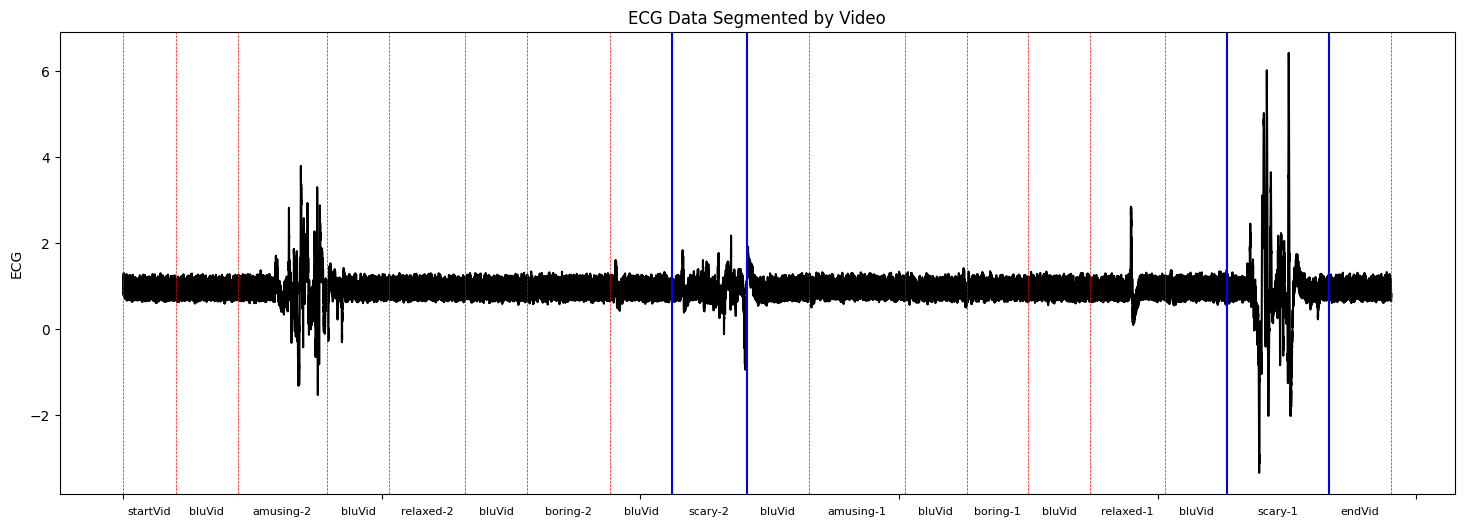

In [327]:
plot_segmented_data(simplified_physio_data, 'ecg', 11)

In [328]:
simplified_physio_data[0].tail(3)

,daqtime,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,video
49029,2451450,0.91204,35.75564,7.24226,27.03226,26.87704,5.90172,5.71434,5.44258,12
49030,2451500,0.94746,35.76266,7.24492,27.03320,26.88074,5.70540,5.78750,5.39482,12
49031,2451550,0.98932,35.71354,7.24486,27.03000,26.87874,5.78178,5.70040,5.29972,12


### Extract specific participant data

In [329]:
# Number of participants in this experiment
num_participants = len(simplified_physio_data)
# Video Sequence of participants. In snippet [1,2], in database [1, ... , 30]
sequences_of_participants = np.array([participant_data.iloc[participant]['sequence'] for participant in range(num_participants)])
# IDs of scary videos
scary_videos_ids = videos_data[videos_data['label'].isin(['scary-1', 'scary-2'])].drop(columns=('label'))['video_id'].tolist()
# IDs of amusing videos
amusing_videos_ids = videos_data[videos_data['label'].isin(['amusing-1', 'amusing-2'])].drop(columns=('label'))['video_id'].tolist()
# IDs of low arousal
low_arousal_videos_ids = videos_data[videos_data['label'].isin(['relaxed-1', 'relaxed-2', 'boring-1', 'boring-2'])].drop(columns=('label'))['video_id'].tolist()

# Initialize interlude time between scary videos for each participant
interlude_durations = np.zeros(num_participants)
# Initialize ECG and time array
max_hr = np.zeros((num_participants, 4))
# Initialize GSR and time array
max_gsr = np.zeros((num_participants, 4))
# Initialize count and time of low arousal videos before the 2nd scary video
count_time_low_before_2nd = np.zeros((num_participants, 2))
# Initialize count of interlude videos total
count_interlude_videos_total = np.zeros(num_participants)
# Initialize count of interlude low arousal
count_interlude_low_arousal = np.zeros(num_participants)
# Initialize log ratio (low arousal / total interlude)
logratio_low_div_total = np.zeros(num_participants)
# Initialize min ECG
min_hr = np.zeros((num_participants, 2))
# Initialize distance between min and max ECG
distance_min_max_hr = np.zeros((num_participants, 2))

for participant in range(num_participants):
  print('\n','#'*15, f'Participant {participant + 1}', '#'*15)
  participant_sequence = pd.DataFrame(sequence_order_data.iloc[:, sequences_of_participants[participant] -1])  # -1 because the sequence data start from 1 but the df rows start from 0

  # Get indices of scary videos for the current participant
  scary_indices = participant_sequence[participant_sequence[f'sub_{participant+1}'].isin(scary_videos_ids)].index
  scary_ids = participant_sequence[participant_sequence[f'sub_{participant+1}'].isin(scary_videos_ids)][f'sub_{participant+1}'].values.tolist()

  if len(scary_indices) >= 2:
      # Extract the first two indices if more than one scary video is found
      first_scary_loc, second_scary_loc = scary_indices[0], scary_indices[1]
      # Extract start times of the first and second scary video
      first_scary_start_time = simplified_physio_data[participant][simplified_physio_data[participant]['video'] == scary_ids[0]]['daqtime'].iloc[0]
      second_scary_start_time = simplified_physio_data[participant][simplified_physio_data[participant]['video'] == scary_ids[1]]['daqtime'].iloc[0]

      # Print the indices of the scary videos
      print(f'Scary videos order: {scary_ids} with indeces: {first_scary_loc} and {second_scary_loc}')

      ######################## Extract the interlude videos ########################
      if second_scary_loc > first_scary_loc + 1:
          interlude_videos = participant_sequence.iloc[first_scary_loc + 1:second_scary_loc][f'sub_{participant+1}'].values.tolist()
          count_interlude_videos_total[participant] = np.floor(len(interlude_videos)/2)
          print(f'Interlude videos: {interlude_videos}, Without BlueVid: {count_interlude_videos_total[participant]}')
          count_interlude_low_arousal[participant] = len([vid for vid in interlude_videos if vid in low_arousal_videos_ids])
      else:
          print("No interlude videos between the two scary videos.")
          count_interlude_videos_total[participant] = 0
          count_interlude_low_arousal[participant] = 0
      print('Low arousal videos:',count_interlude_low_arousal[participant])
      
      # Compute log ratio 
      logratio_low_div_total[participant] = np.around(np.log((count_interlude_low_arousal[participant] + 1)/(count_interlude_videos_total[participant] + 1)), decimals=4)
      
      ######################## Compute the duration of the interlude videos ########################
      interlude_durations[participant] = sum([
                duration_data[duration_data['video_id'] == video]['duration'].values[0]
                for video in interlude_videos if not duration_data[duration_data['video_id'] == video].empty
            ])
      print(f'Interlude duration: {interlude_durations[participant]} ms')

      ######################## Compute count and place of interlude amusing videos ########################
      if amusing_videos_ids[0] in interlude_videos or amusing_videos_ids[1] in interlude_videos:
        amusing_vid_places = []
        for i, video in enumerate(interlude_videos):
          if video in amusing_videos_ids:
            amusing_vid_places.append(i+1)

        amusing_video_comments = []
        for video_place in amusing_vid_places:
          if video_place <= len(interlude_videos)/2:
            amusing_video_comments.append('early')
          else:
            amusing_video_comments.append('late')

        print(f'The interlude amusing videos appear in places: {amusing_vid_places}, ({amusing_video_comments})')

        # Compute low arousal videos before 2nd scary video #
        count_low_arousal_before_2nd_scary = len(interlude_videos) - amusing_vid_places[-1]
        print(f'Low arousal videos before 2nd scary video: {count_low_arousal_before_2nd_scary} {np.floor(count_low_arousal_before_2nd_scary/2)}')
        count_time_low_before_2nd[participant][0] = np.floor(count_low_arousal_before_2nd_scary/2)

        # Compute low arousal time before 2nd scary video #
        count_time_low_before_2nd[participant][1] = sum([
                duration_data[duration_data['video_id'] == video]['duration'].values[0]
                for video in interlude_videos[-count_low_arousal_before_2nd_scary:] if not duration_data[duration_data['video_id'] == video].empty
            ])
      else:
        # No amusing so all the interlude time is low-arousal
        low_arousal_videos = np.floor(len(interlude_videos)/2)
        print(f'Low arousal videos before 2nd scary video: {low_arousal_videos}')
        count_time_low_before_2nd[participant][0] = low_arousal_videos
        count_time_low_before_2nd[participant][1] = interlude_durations[participant]

      print(f'Count and duration of uninterrupted low arousal videos before 2nd scary video: {int(count_time_low_before_2nd[participant][0])}, {count_time_low_before_2nd[participant][1]}')


      ######################## Compute peak and lowest ECG (HR) and GSR for each scary video ########################
      for idx, loc in enumerate([first_scary_loc, second_scary_loc]):
        video_id = scary_ids[idx]
        start_time = first_scary_start_time if idx == 0 else second_scary_start_time
        filtered_data = simplified_physio_data[participant][simplified_physio_data[participant]['video'] == video_id]

        peak_ecg_row = filtered_data[filtered_data['ecg'] == filtered_data['ecg'].max()]
        peak_gsr_row = filtered_data[filtered_data['gsr'] == filtered_data['gsr'].max()]

        # Adjust peak times by subtracting the start time of the video
        peak_ecg_time_adjusted = peak_ecg_row['daqtime'].values[0] - start_time
        peak_gsr_time_adjusted = peak_gsr_row['daqtime'].values[0] - start_time

        max_hr[participant][idx*2] = peak_ecg_time_adjusted
        max_hr[participant][idx*2+1] = peak_ecg_row['ecg'].values[0]
        max_gsr[participant][idx*2] = peak_gsr_time_adjusted
        max_gsr[participant][idx*2+1] = peak_gsr_row['gsr'].values[0]
        
        # Compute the lowest ECG value
        min_hr_row = filtered_data[filtered_data['ecg'] == filtered_data['ecg'].min()]
        min_hr[participant][idx] = min_hr_row['ecg'].values[0]
                

        print(f'Video {video_id}: Peak ECG {max_hr[participant][idx*2+1]} at {max_hr[participant][idx*2]} (relative time)')
        print(f'Video {video_id}: Peak GSR {max_gsr[participant][idx*2+1]} at {max_gsr[participant][idx*2]} (relative time)')
        print(f'Video {video_id}: Min ECG {min_hr[participant][idx]} and distance from max: {distance_min_max_hr[participant][idx]}')

  else:
      print("Less than two scary videos found for participant.")  # In case of problem with data.

data = {
    'Part.': range(1, num_participants + 1),
    'Interl. Dur.': interlude_durations[:],
    'Interl. Vid. Count': count_interlude_videos_total[:],
    'Interl. Low Ar.': count_interlude_low_arousal[:],
    'Ratio': logratio_low_div_total[:],
    
    'Low Ar. vid. bfr 2nd': count_time_low_before_2nd[:, 0],
    'Low Ar. time bfr 2nd': count_time_low_before_2nd[:, 1],
    
    'Max HR 1st': max_hr[:, 1],
    'Min HR 1st': min_hr[:, 0],
    'HR 1st Dist.': max_hr[:, 1] - min_hr[:, 0],
    'Max HR 1st Time': max_hr[:, 0],
    
    
    'Max HR 2nd': max_hr[:, 3],
    'Min HR 2nd': min_hr[:, 1],
    'HR 2nd Dist.': max_hr[:, 3] - min_hr[:, 1],
    'Max HR 2nd Time': max_hr[:, 2],
    
    'Diff. HR': max_hr[:, 3] - max_hr[:, 1],
    'Diff. HR Time': max_hr[:, 2] - max_hr[:, 0],
        
    'Max GSR 1st': max_gsr[:, 1],
    'Max GSR 1st Time': max_gsr[:, 0],  
    'Max GSR 2nd': max_gsr[:, 3],
    'Max GSR 2nd Time': max_gsr[:, 2],
    
    'Diff. GSR': max_gsr[:, 3] - max_gsr[:, 1],
    'Diff. GSR Time': max_gsr[:, 2] - max_gsr[:, 0],
}
results_df = pd.DataFrame(data)

name = 'results_data_full.csv'
results_df.to_csv(name, index=False)

results_df.to_csv(metadata_folder+'/'+name, index=False)



 ############### Participant 1 ###############
Scary videos order: [7, 8] with indeces: 8 and 16
Interlude videos: [11, 4, 11, 2, 11, 6, 11], Without BlueVid: 3.0
Low arousal videos: 2.0
Interlude duration: 959958.333 ms
The interlude amusing videos appear in places: [4], (['late'])
Low arousal videos before 2nd scary video: 3 1.0
Count and duration of uninterrupted low arousal videos before 2nd scary video: 1, 386750.0
Video 7: Peak ECG 2.23004 at 84700.0 (relative time)
Video 7: Peak GSR 17.22866 at 180950.0 (relative time)
Video 7: Min ECG -1.8025200000000001 and distance from max: 0.0
Video 8: Peak ECG 1.4118000000000002 at 20550.0 (relative time)
Video 8: Peak GSR 6.95756 at 143650.0 (relative time)
Video 8: Min ECG 0.22976 and distance from max: 0.0

 ############### Participant 2 ###############
Scary videos order: [8, 7] with indeces: 8 and 16
Interlude videos: [11, 1, 11, 3, 11, 5, 11], Without BlueVid: 3.0
Low arousal videos: 2.0
Interlude duration: 929375.0 ms
The interlude

In [331]:
results_df.head(10)

,Part.,Interl. Dur.,Interl. Vid. Count,Interl. Low Ar.,Ratio,Low Ar. vid. bfr 2nd,Low Ar. time bfr 2nd,Max HR 1st,Min HR 1st,HR 1st Dist.,...,HR 2nd Dist.,Max HR 2nd Time,Diff. HR,Diff. HR Time,Max GSR 1st,Max GSR 1st Time,Max GSR 2nd,Max GSR 2nd Time,Diff. GSR,Diff. GSR Time
0,1,959958.333,3.0,2.0,0.1818,1.0,386750.000,2.23004,-1.80252,4.03256,...,1.18204,20550.0,-0.81824,-64150.0,17.22866,180950.0,6.95756,143650.0,-10.27110,-37300.0
1,2,929375.000,3.0,2.0,0.1818,2.0,623791.667,1.43978,0.36098,1.07880,...,1.07774,92650.0,-0.00454,-27900.0,29.15166,143700.0,36.12306,65500.0,6.97140,-78200.0
2,3,1237458.333,4.0,2.0,0.1667,1.0,400125.000,1.47990,0.25054,1.22936,...,1.23608,139700.0,-0.01722,-43950.0,29.56686,181300.0,26.47600,115850.0,-3.09086,-65450.0
3,4,890541.667,3.0,3.0,0.2727,3.0,890541.667,1.65250,0.59108,1.06142,...,3.93486,69200.0,0.67952,-49550.0,29.88456,143700.0,44.92622,196900.0,15.04166,53200.0
4,5,623791.667,2.0,2.0,0.2000,2.0,623791.667,1.54270,0.32096,1.22174,...,1.12218,64250.0,-0.01244,-100800.0,38.88224,187400.0,37.46280,141200.0,-1.41944,-46200.0
5,6,693208.333,2.0,1.0,0.1000,0.0,120000.000,1.86086,0.32404,1.53682,...,2.35716,118000.0,0.01628,-23950.0,50.21434,142850.0,50.32994,125750.0,0.11560,-17100.0
6,7,998791.666,3.0,1.0,0.0909,0.0,120000.000,1.51530,0.26874,1.24656,...,0.57336,42250.0,-0.27786,-72850.0,52.95398,124750.0,41.27768,143650.0,-11.67630,18900.0
7,8,959958.333,3.0,2.0,0.1818,1.0,386750.000,1.82936,-0.80434,2.63370,...,1.00772,133650.0,-0.40134,3100.0,28.51538,139550.0,17.23442,142150.0,-11.28096,2600.0
8,9,929375.000,3.0,2.0,0.1818,0.0,120000.000,2.06080,-0.61128,2.67208,...,2.45544,73200.0,-0.05906,-49250.0,24.01722,143700.0,39.40618,125600.0,15.38896,-18100.0
9,10,1769333.333,6.0,4.0,0.2857,1.0,385125.000,1.44864,0.53440,0.91424,...,0.89622,156700.0,0.00022,116150.0,29.44844,140900.0,32.83318,118750.0,3.38474,-22150.0


### Take half of bluVid as actual video

In [300]:
num_participants = len(physio_data)
# Video Sequence of participants. In snippet [1,2], in database [1, ... , 30]
sequences_of_participants = np.array([participant_data.iloc[participant]['sequence'] for participant in range(num_participants)])
scary_videos_ids = videos_data[videos_data['label'].isin(['scary-1', 'scary-2'])].drop(columns=('label'))['video_id'].tolist()

new_data = simplified_physio_data.copy()

for participant in range(num_participants):
    participant_sequence = pd.DataFrame(sequence_order_data.iloc[:, sequences_of_participants[participant] -1])  # -1 because the sequence data start from 1 but the df rows start from 0
    
    # Extract video IDs for the participant
    video_ids = simplified_physio_data[participant]['video'].tolist()
    
    i = 0
    while i < len(video_ids) - 1:
        current_video_id = video_ids[i]
        
        if current_video_id not in [10, 11, 12] and video_ids[i + 1] in [11, 12]:
            # Find the end of the current video and start of the blue screen
            start_neutral_video = i + 1
            while start_neutral_video < len(video_ids) and video_ids[start_neutral_video] in [11, 12]:
                start_neutral_video += 1
            end_blue = start_neutral_video - 1
        
            # Calculate the number of blue screen samples to reassign
            num_blue_samples = end_blue - (i + 1) + 1
            half_blue_samples = num_blue_samples // 2 + num_blue_samples // 4
            
            # Reassign half of the blue screen samples to the current video
            video_ids[i + 1:i + 1 + half_blue_samples] = [current_video_id] * half_blue_samples
            
            # Move to the end of the blue screen to continue
            i = end_blue

        i += 1
    
    new_data[participant]['video'] = video_ids



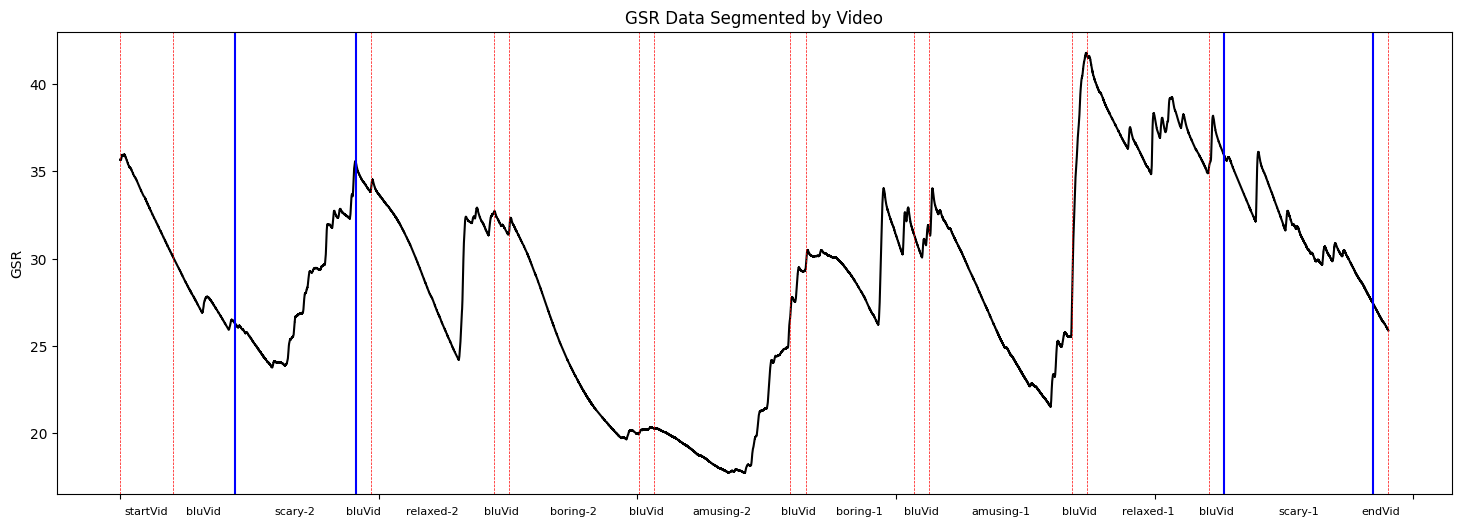

In [301]:
plot_segmented_data(new_data, 'gsr', 1)

In [ ]:
# Number of participants in this experiment
num_participants = len(new_data)
# Video Sequence of participants. In snippet [1,2], in database [1, ... , 30]
sequences_of_participants = np.array([participant_data.iloc[participant]['sequence'] for participant in range(num_participants)])
# IDs of scary videos
scary_videos_ids = videos_data[videos_data['label'].isin(['scary-1', 'scary-2'])].drop(columns=('label'))['video_id'].tolist()
# IDs of amusing videos
amusing_videos_ids = videos_data[videos_data['label'].isin(['amusing-1', 'amusing-2'])].drop(columns=('label'))['video_id'].tolist()
# IDs of low arousal
low_arousal_videos_ids = videos_data[videos_data['label'].isin(['relaxed-1', 'relaxed-2', 'boring-1', 'boring-2'])].drop(columns=('label'))['video_id'].tolist()

# Initialize interlude time between scary videos for each participant
interlude_durations = np.zeros(num_participants)
# Initialize ECG and time array
max_hr = np.zeros((num_participants, 4))
# Initialize GSR and time array
max_gsr = np.zeros((num_participants, 4))
# Initialize count and time of low arousal videos before the 2nd scary video
count_time_low_before_2nd = np.zeros((num_participants, 2))
# Initialize count of interlude videos total
count_interlude_videos_total = np.zeros(num_participants)
# Initialize count of interlude low arousal
count_interlude_low_arousal = np.zeros(num_participants)
# Initialize log ratio (low arousal / total interlude)
logratio_low_div_total = np.zeros(num_participants)
# Initialize min ECG
min_hr = np.zeros((num_participants, 2))
# Initialize distance between min and max ECG
distance_min_max_hr = np.zeros((num_participants, 2))

for participant in range(num_participants):
  print('\n','#'*15, f'Participant {participant + 1}', '#'*15)
  participant_sequence = pd.DataFrame(sequence_order_data.iloc[:, sequences_of_participants[participant] -1])  # -1 because the sequence data start from 1 but the df rows start from 0

  # Get indices of scary videos for the current participant
  scary_indices = participant_sequence[participant_sequence[f'sub_{participant+1}'].isin(scary_videos_ids)].index
  scary_ids = participant_sequence[participant_sequence[f'sub_{participant+1}'].isin(scary_videos_ids)][f'sub_{participant+1}'].values.tolist()

  if len(scary_indices) >= 2:
      # Extract the first two indices if more than one scary video is found
      first_scary_loc, second_scary_loc = scary_indices[0], scary_indices[1]
      # Extract start times of the first and second scary video
      first_scary_start_time = new_data[participant][new_data[participant]['video'] == scary_ids[0]]['daqtime'].iloc[0]
      second_scary_start_time = new_data[participant][new_data[participant]['video'] == scary_ids[1]]['daqtime'].iloc[0]

      # Print the indices of the scary videos
      print(f'Scary videos order: {scary_ids} with indeces: {first_scary_loc} and {second_scary_loc}')

      ######################## Extract the interlude videos ########################
      if second_scary_loc > first_scary_loc + 1:
          interlude_videos = participant_sequence.iloc[first_scary_loc + 1:second_scary_loc][f'sub_{participant+1}'].values.tolist()
          count_interlude_videos_total[participant] = np.floor(len(interlude_videos)/2)
          print(f'Interlude videos: {interlude_videos}, Without BlueVid: {count_interlude_videos_total[participant]}')
          count_interlude_low_arousal[participant] = len([vid for vid in interlude_videos if vid in low_arousal_videos_ids])
      else:
          print("No interlude videos between the two scary videos.")
          count_interlude_videos_total[participant] = 0
          count_interlude_low_arousal[participant] = 0
      print('Low arousal videos:',count_interlude_low_arousal[participant])
      
      # Compute log ratio 
      logratio_low_div_total[participant] = np.around((count_interlude_low_arousal[participant])/(count_interlude_videos_total[participant] + 8), decimals=4)
      
      ######################## Compute the duration of the interlude videos ########################
      interlude_durations[participant] = sum([
                duration_data[duration_data['video_id'] == video]['duration'].values[0]
                for video in interlude_videos if not duration_data[duration_data['video_id'] == video].empty
            ])
      print(f'Interlude duration: {interlude_durations[participant]} ms')

      ######################## Compute count and place of interlude amusing videos ########################
      if amusing_videos_ids[0] in interlude_videos or amusing_videos_ids[1] in interlude_videos:
        amusing_vid_places = []
        for i, video in enumerate(interlude_videos):
          if video in amusing_videos_ids:
            amusing_vid_places.append(i+1)

        amusing_video_comments = []
        for video_place in amusing_vid_places:
          if video_place <= len(interlude_videos)/2:
            amusing_video_comments.append('early')
          else:
            amusing_video_comments.append('late')

        print(f'The interlude amusing videos appear in places: {amusing_vid_places}, ({amusing_video_comments})')

        # Compute low arousal videos before 2nd scary video #
        count_low_arousal_before_2nd_scary = len(interlude_videos) - amusing_vid_places[-1]
        print(f'Low arousal videos before 2nd scary video: {count_low_arousal_before_2nd_scary} {np.floor(count_low_arousal_before_2nd_scary/2)}')
        count_time_low_before_2nd[participant][0] = np.floor(count_low_arousal_before_2nd_scary/2)

        # Compute low arousal time before 2nd scary video #
        count_time_low_before_2nd[participant][1] = sum([
                duration_data[duration_data['video_id'] == video]['duration'].values[0]
                for video in interlude_videos[-count_low_arousal_before_2nd_scary:] if not duration_data[duration_data['video_id'] == video].empty
            ])
      else:
        # No amusing so all the interlude time is low-arousal
        low_arousal_videos = np.floor(len(interlude_videos)/2)
        print(f'Low arousal videos before 2nd scary video: {low_arousal_videos}')
        count_time_low_before_2nd[participant][0] = low_arousal_videos
        count_time_low_before_2nd[participant][1] = interlude_durations[participant]

      print(f'Count and duration of uninterrupted low arousal videos before 2nd scary video: {int(count_time_low_before_2nd[participant][0])}, {count_time_low_before_2nd[participant][1]}')


      ######################## Compute peak and lowest ECG (HR) and GSR for each scary video ########################
      for idx, loc in enumerate([first_scary_loc, second_scary_loc]):
        video_id = scary_ids[idx]
        start_time = first_scary_start_time if idx == 0 else second_scary_start_time
        filtered_data = new_data[participant][new_data[participant]['video'] == video_id]

        peak_ecg_row = filtered_data[filtered_data['ecg'] == filtered_data['ecg'].max()]
        peak_gsr_row = filtered_data[filtered_data['gsr'] == filtered_data['gsr'].max()]

        # Adjust peak times by subtracting the start time of the video
        peak_ecg_time_adjusted = peak_ecg_row['daqtime'].values[0] - start_time
        peak_gsr_time_adjusted = peak_gsr_row['daqtime'].values[0] - start_time

        max_hr[participant][idx*2] = peak_ecg_time_adjusted
        max_hr[participant][idx*2+1] = peak_ecg_row['ecg'].values[0]
        max_gsr[participant][idx*2] = peak_gsr_time_adjusted
        max_gsr[participant][idx*2+1] = peak_gsr_row['gsr'].values[0]
        
        # Compute the lowest ECG value
        min_hr_row = filtered_data[filtered_data['ecg'] == filtered_data['ecg'].min()]
        min_hr[participant][idx] = min_hr_row['ecg'].values[0]
        
        # Compute the distance between the lowest and the highest ECG value
        
        # distance_min_max_hr[participant][idx] = max_hr[participant][idx*2+1] - min_hr[participant][idx]

        print(f'Video {video_id}: Peak ECG {max_hr[participant][idx*2+1]} at {max_hr[participant][idx*2]} (relative time)')
        print(f'Video {video_id}: Peak GSR {max_gsr[participant][idx*2+1]} at {max_gsr[participant][idx*2]} (relative time)')
        print(f'Video {video_id}: Min ECG {min_hr[participant][idx]} and distance from max: {distance_min_max_hr[participant][idx]}')

  else:
      print("Less than two scary videos found for participant.")  # In case of problem with data.

data = {
    'Part.': range(1, num_participants + 1),
    'Interl. Dur.': interlude_durations[:],
    'Interl. Vid. Count': count_interlude_videos_total[:],
    'Interl. Low Ar.': count_interlude_low_arousal[:],
    'Ratio': logratio_low_div_total[:],
    
    'Low Ar. vid. bfr 2nd': count_time_low_before_2nd[:, 0],
    'Low Ar. time bfr 2nd': count_time_low_before_2nd[:, 1],
    
    'Max HR 1st': max_hr[:, 1],
    'Min HR 1st': min_hr[:, 0],
    'HR 1st Dist.': max_hr[:, 1] - min_hr[:, 0],
    'Max HR 1st Time': max_hr[:, 0],
    
    
    'Max HR 2nd': max_hr[:, 3],
    'Min HR 2nd': min_hr[:, 1],
    'HR 2nd Dist.': max_hr[:, 3] - min_hr[:, 1],
    'Max HR 2nd Time': max_hr[:, 2],
    
    'Diff. HR': max_hr[:, 3] - max_hr[:, 1],
    'Diff. HR Time': max_hr[:, 2] - max_hr[:, 0],
        
    'Max GSR 1st': max_gsr[:, 1],
    'Max GSR 1st Time': max_gsr[:, 0],  
    'Max GSR 2nd': max_gsr[:, 3],
    'Max GSR 2nd Time': max_gsr[:, 2],
    
    'Diff. GSR': max_gsr[:, 3] - max_gsr[:, 1],
    'Diff. GSR Time': max_gsr[:, 2] - max_gsr[:, 0],
}
results_df = pd.DataFrame(data)

name = 'results_data_full_2.csv'
results_df.to_csv(name, index=False)

results_df.to_csv(metadata_folder+'/'+name, index=False)

In [308]:
results_df.head(6)

,Part.,Interl. Dur.,Interl. Vid. Count,Interl. Low Ar.,Ratio,Low Ar. vid. bfr 2nd,Low Ar. time bfr 2nd,Max HR 1st,Min HR 1st,HR 1st Dist.,...,HR 2nd Dist.,Max HR 2nd Time,Diff. HR,Diff. HR Time,Max GSR 1st,Max GSR 1st Time,Max GSR 2nd,Max GSR 2nd Time,Diff. GSR,Diff. GSR Time
0,1,959958.333,3.0,2.0,0.1818,1.0,386750.000,2.23004,-1.80252,4.03256,...,1.20690,20550.0,-0.81824,-64150.0,17.22866,180950.0,7.73578,185600.0,-9.49288,4650.0
1,2,929375.000,3.0,2.0,0.1818,2.0,623791.667,1.70030,0.23932,1.46098,...,1.16056,267250.0,-0.23220,93250.0,35.59026,232900.0,36.12306,65500.0,0.53280,-167400.0
2,3,1237458.333,4.0,2.0,0.1667,1.0,400125.000,1.47990,0.25054,1.22936,...,3.10050,226100.0,0.62104,42450.0,29.56686,181300.0,27.63496,193300.0,-1.93190,12000.0
3,4,890541.667,3.0,3.0,0.2727,3.0,890541.667,1.65250,0.43176,1.22074,...,3.93486,69200.0,0.67952,-49550.0,33.34366,169000.0,45.17462,205200.0,11.83096,36200.0
4,5,623791.667,2.0,2.0,0.2000,2.0,623791.667,2.09800,0.32096,1.77704,...,1.12218,64250.0,-0.56774,-132750.0,38.88224,187400.0,37.46280,141200.0,-1.41944,-46200.0
5,6,693208.333,2.0,1.0,0.1000,0.0,120000.000,1.86086,0.23452,1.62634,...,2.35716,118000.0,0.01628,-23950.0,50.21434,142850.0,50.32994,125750.0,0.11560,-17100.0


# Playground

##TODO:

In [304]:
# We need a combined csv with the data showing in a specific format so that we can run a preliminary correlation and keep tweaking the exact metric until we find something :).
# I will get back to you witht eh exact format we need for a correlation and a regression

## Plot HR and GSR for scary videos

In [305]:
def plot_scary_videos_physio(sub_nums, base_dir):
    for sub_num in sub_nums:
        print(f"\n----------- Participant {sub_num} data -----------------\n")
        data_path = os.path.join(base_dir, f"sub_{sub_num}.csv")
        data = pd.read_csv(data_path)

        # Keep videos 7 and 8 (scary)
        video_7_data = data[data['video'] == 7]
        video_8_data = data[data['video'] == 8]

        # Create combined fig
        plt.figure(figsize=(14, 12))

        # Plot ECG for video 7
        plt.subplot(2, 2, 1)
        plt.plot(video_7_data['daqtime'], video_7_data['ecg'], color='blue')
        plt.title('ECG Data for Video 7')
        plt.xlabel('Time (s)')
        plt.ylabel('ECG amplitude')

        # Plot ECG for video 8
        plt.subplot(2, 2, 2)
        plt.plot(video_8_data['daqtime'], video_8_data['ecg'], color='blue')
        plt.title('ECG Data for Video 8')
        plt.xlabel('Time (s)')
        plt.ylabel('ECG amplitude')

        # Plot GSR video 7
        plt.subplot(2, 2, 3)
        plt.plot(video_7_data['daqtime'], video_7_data['gsr'], color='green')
        plt.title('GSR Data for Video 7')
        plt.xlabel('Time (s)')
        plt.ylabel('GSR (μS)')

        # Plot GSR video 8
        plt.subplot(2, 2, 4)
        plt.plot(video_8_data['daqtime'], video_8_data['gsr'], color='green')
        plt.title('GSR Data for Video 8')
        plt.xlabel('Time (s)')
        plt.ylabel('GSR (μS)')


        plt.tight_layout()
        plt.show()


In [306]:
# Load your CSV file
df = pd.read_csv('results_data_full_2.csv')

# Compute the correlation matrix for the DataFrame
correlation_matrix = df.corr()

# Assuming the first six columns are the columns of interest
columns_of_interest = df.columns[1:7]
all_other_columns = df.columns[7:]  # Modify if different columns are of interest

# Create a new DataFrame to store the correlations
filtered_correlations = pd.DataFrame()

for col in columns_of_interest:
    # Extract correlations of 'col' with all other columns
    correlations = correlation_matrix[col][all_other_columns]
    # Store these correlations in the new DataFrame
    filtered_correlations[col] = correlations

# Save the filtered correlations to a new CSV file
filtered_correlations.to_csv('filtered_correlations.csv')

print("Filtered correlations have been saved to 'filtered_correlations.csv'.")


Filtered correlations have been saved to 'filtered_correlations.csv'.


In [307]:
filtered_correlations

,Interl. Dur.,Interl. Vid. Count,Interl. Low Ar.,Ratio,Low Ar. vid. bfr 2nd,Low Ar. time bfr 2nd
Max HR 1st,-0.125038,-0.111551,0.001982,0.045072,-0.071663,-0.079371
Min HR 1st,0.156181,0.152498,0.054789,0.009809,0.025077,0.027085
HR 1st Dist.,-0.145978,-0.137232,-0.028134,0.017471,-0.049404,-0.054351
Max HR 1st Time,-0.210975,-0.211549,-0.195727,-0.183443,0.037142,0.036767
Max HR 2nd,-0.056867,-0.032029,0.173444,0.247648,0.145386,0.135059
Min HR 2nd,0.152978,0.121429,-0.076795,-0.152944,-0.201722,-0.190195
HR 2nd Dist.,-0.106869,-0.077575,0.133816,0.212405,0.179870,0.168475
Max HR 2nd Time,-0.058290,-0.056818,-0.030634,-0.051850,0.254883,0.267943
Diff. HR,0.031166,0.045669,0.164299,0.205712,0.187847,0.183253
Diff. HR Time,0.114844,0.116475,0.125493,0.098914,0.177504,0.188348
